# Cálculo de vano isostático de pretensado

Sección rectangular 2000*500 mm (pasarela estrecha)

Materiales
- Hormigón : HA-40
- Acero: B-500S
- Acero pretensar: Y1860 S7
            


In [2]:
# Definición de la sección
B = 2000
h = 500

Ac = B * h / 1000000
Ic = 1/12 * (B / 1000) * (h / 1000) **3
W = Ic / (h / 2000)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20.0, 4.0)

In [4]:
#Definición de trazado

#Longitud del vano

L = 20000

#Cota de arranque
y0 = 250

#Cota final
yf = 250

#Cota mínima
ymin = 150

#Longitud inicial de recta
Lr1 = 1500

#Longitud final de recta
Lr2 = 1500

#Longitud parábola izquierda
Lp1 = 10000 - Lr1

#Longitud parábola derecha
Lp2 = L - Lr1 - Lr2 - Lp1


#Materiales
Ep = 185000 #Módulo de elasticidad del acero de pretensar
Ec = 32000  #Módulo de elasticidad del hormigón
fck = 40000 #Resistencia del hormigón en kPa
fpyk = 1860

#Definición de pretensado

n_a = 6   #Número de anclajes
n_t = 12  # Número de cordones en cada anclaje
a_1 = 140 #Sección de cada cordón
Ap = n_a * n_t * a_1 #Sección de pretensado (mm2)
sigma_0 = 0.78 * fpyk
P0 = sigma_0 * Ap / 1000 #Dividimos entre 1000 para tener P0 en kN

a = 2 #Penetración de cuñas (mm)
mu = 0.18
k = 0.0049 / mu



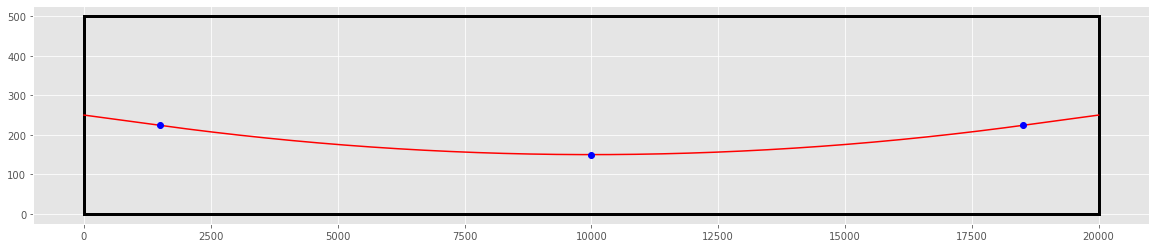

In [5]:
#Cálculo del trazado
a1 = (y0 - ymin) /(Lp1**2 + 2 * Lp1 * Lr1)
a2 = (yf - ymin) /(Lp2**2 + 2 * Lp2 * Lr2)
p1 = 2 * a1 * Lp1
p2 = 2 * a2 * Lp2
y1 = ymin + a1 * Lp1**2
y2 = ymin + a2 * Lp2**2

num_p = 1000 #Número de puntos que queremos calcular del trazado
xp = np.linspace(0, L, num_p)
yp=[]

for i in xp:
    if i < Lr1:
        yp.append(y0 - p1 * i)
    elif i < (Lr1 + Lp1):
        yp.append(ymin + a1 * (Lr1 + Lp1 - i)**2)
    elif i < (Lr1 + Lp1 + Lp2):
        yp.append(ymin + a2 * (i - Lr2 - Lp1)**2)
    else:
        yp.append(yf - p2 * (L-i))
yp = np.array (yp)
fig,ax = plt.subplots()
ax.plot (xp, yp, c='red')
ax.add_patch(pat.Rectangle ((0,0), L, 500 , edgecolor= 'black', lw=3, facecolor = None, fill=False))
ax.plot (Lr1, y1, 'o', c='blue')
ax.plot (L - Lr2, y2, 'o', c='blue')
ax.plot (L - Lr2 - Lp2, ymin, 'o', c='blue')

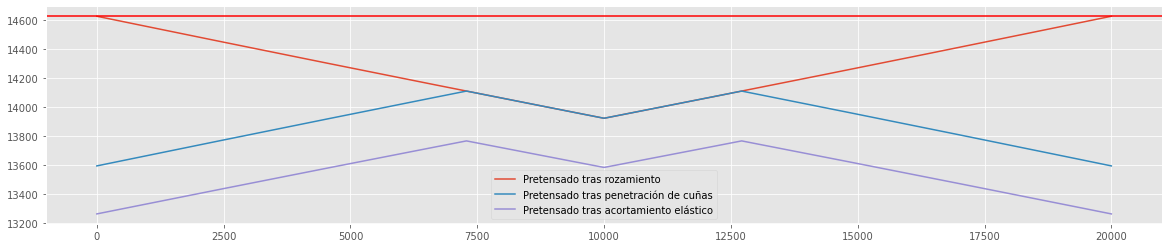

In [9]:
#Cálculo de la fuerza de pretensado

#Pretensado inicial
P = np.full((1, num_p), P0) 
dL = xp[1] - xp[0]
#Pérdidas por rozamiento
theta1 = np.diff (yp) / dL 
theta1 = np.diff (theta1) / dL
theta1 = np.insert (theta1, 0, 0.0)
theta1 = np.append (theta1, 0.0)
theta1 = np.cumsum (theta1)

ypr = np.flip(yp)
theta2 = np.diff (ypr) / dL 
theta2 = np.diff (theta2) / dL
theta2 = np.insert (theta2, 0, 0.0)
theta2 = np.append (theta2, 0.0)
theta2 = np.cumsum (theta2)
theta2 = np.flip(theta2)


DP1i = np.exp(-mu*(theta1 + k*(xp/1000.0))) #Fuerza de pretensado tras pérdidas desde anclaje izquierdo
DP1d = np.exp(-mu*(theta2 + k*((L-xp)/1000.0))) #Fuerza de pretensado tras pérdidas desde anclaje derecho
DP1 = P0 * np.maximum (DP1i, DP1d)
plt.plot (xp, DP1, label = 'Pretensado tras rozamiento')

#Pérdidas por penetración de cuñas

#Hay que buscar dónde se produce el punto neutro
#Desde punto inicial
alargamiento = 0.0
i = 0

a_ = a * Ep * Ap / dL / 2000.0
while ((alargamiento < a_) and (i < len(xp)/2.0)):
    i = i + 1
    Ps = DP1[:i]
    alargamiento = np.sum(Ps) - len(Ps) * Ps[-1]
#Desde punto final
Pr = np.flip(DP1) #Le damos la vuelta para hacer lo mismo que antes desde el final
alargamiento = 0.0
j = 0
while ((alargamiento < a_) and (j < len(xp)/2.0)):
    j = j + 1
    Psj = DP1[:j]
    alargamiento = np.sum(Psj) - len(Psj) * Psj[-1]
DP2 = np.copy(DP1)
DP2[:i] = 2 * Ps[-1] - DP1[:i]
DP2[-j:] = 2 * Psj[-1] - DP1[-j:]
plt.plot(xp, DP2, label= 'Pretensado tras penetración de cuñas')

#Pérdidas por acortamiento elástico
factor = (n_a - 1) / (2 * n_a) * Ep * Ap / Ec / 2000 / 500
DP3 = DP2 * (1-factor)
plt.plot (xp,DP3, label='Pretensado tras acortamiento elástico')
plt.axhline (P0, c='red')
plt.legend()


## Obtención de esfuerzos
Consideramos las siguientes cargas

- Peso propio
- Sobrecarga (5 kN/m2)

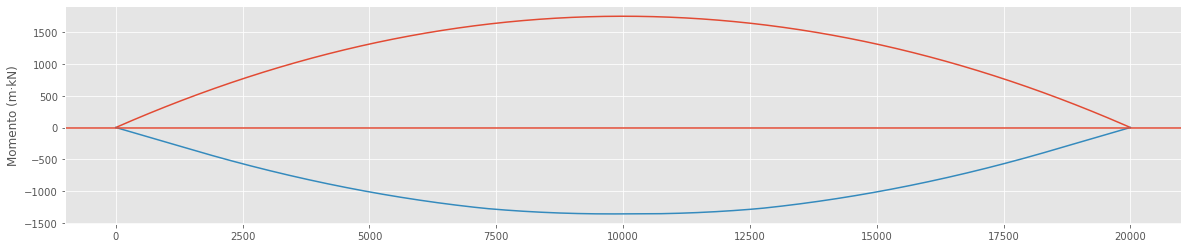

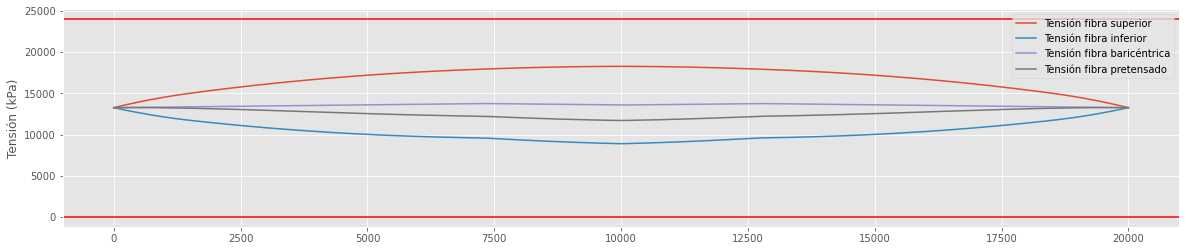

8887.42071806084


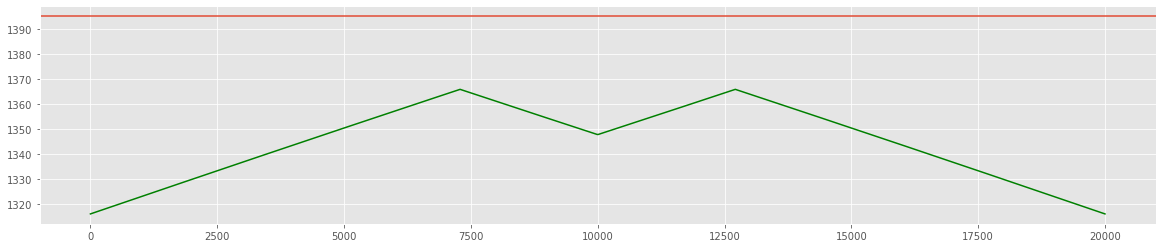

In [7]:
pp = 25 * Ac # Carga de peso propio
sc = 5 * B / 1000.0 #Sobrecarga de uso
M = (pp + sc) * (L/1000) /2.0 * (xp / 1000) - (pp + sc) * (xp/1000)**2/2.0 
Mp =  DP3 * (-250.0 + yp) / 1000

plt.plot (xp, M)
plt.plot (xp, Mp)
plt.axhline(0.0)
plt.ylabel ('Momento (m·kN)')
plt.show()

tens_s = DP3 / Ac + (M + Mp) / W
tens_i = DP3 / Ac - (M + Mp) / W
tens_p = DP3 / Ac - (M + Mp) / Ic * (0.25 - yp/1000.0)
tens_c = DP3 / Ac

plt.plot (xp, tens_s, label='Tensión fibra superior')
plt.plot (xp, tens_i, label='Tensión fibra inferior')
plt.plot (xp, tens_c, label='Tensión fibra baricéntrica')
plt.plot (xp, tens_p, label='Tensión fibra pretensado')
plt.ylabel('Tensión (kPa)')
plt.axhline (0.0, c='red')
plt.axhline (40000 * 0.6, c= 'red')
plt.legend()
plt.show()

plt.plot (xp, DP3/Ap*1000.0, c='green')
plt.axhline (0.75*fpyk)

print (np.min (tens_i))